<a href="https://colab.research.google.com/github/mohamed0998/CNN-MNIST-dataset-/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the relevant packages

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

Before continuing with our model and training, our first job is to preprocess the dataset
This is a very important step in all of machine learning

The MNIST dataset is, in general, highly processed already - after all its 28x28 grayscale images of clearly visible digits
Thus, our preprocessing will be limited to scaling the pixel values, shuffling the data and creating a validation set
 NOTE: When finally deploying a model in practice, it might be a good idea to include the prerpocessing as initial layers
In that way, the users could just plug the data (images) directly, instead of being required to resize/rescale it before

# Defining some constants/hyperparameters




In [ ]:

BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128
NUM_EPOCHS = 20

# Downloading the MNIST dataset

When 'with_info' is set to True, tfds.load() returns two variables: 
 - the dataset (including the train and test sets) 
 - meta info regarding the dataset itself

In [ ]:
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Extracting the train and test datasets
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

Creating a function to scale our image data (it is recommended to scale the pixel values in the range [0,1] )

In [ ]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [ ]:
# Scaling the data
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [ ]:
# Defining the size of the validation set
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [ ]:
# Defining the size of the test set
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [ ]:
# Reshuffling the dataset
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [ ]:
# Splitting the dataset into training + validation
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [ ]:
# Batching the data
# NOTE: For proper functioning of the model, we need to create one big batch for the validation and test sets
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples) 
test_data = test_data.batch(num_test_samples)

## Creating the model and training it

 Now that we have preprocessed the dataset, we can define our CNN and train it

In [15]:
# Outlining the model/architecture of our CNN
# CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    # (2,2) is the default pool size so we could have just used MaxPooling2D() with no explicit arguments
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10) # You can apply softmax activation here, see below for comentary
])

A brief summary of the model and parameters


In [16]:
model.summary(line_length = 75)

Model: "sequential"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 12, 12, 50)            0           
                                                                           
 conv2d_1 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_1 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten (Flatten)               (None, 1250)                  0           
                                                                           
 dense (Dense)                   (None, 10)                    12510

# Defining the loss function

- In general, our model needs to output probabilities of each class, 
- which can be achieved with a softmax activation in the last dense layer

- However, when using the softmax activation, the loss can rarely be unstable

- Thus, instead of incorporating the softmax into the model itself,
- we use a loss calculation that automatically corrects for the missing softmax
- That is the reason for 'from_logits=True'


In [18]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Compiling the model with Adam optimizer and the cathegorical crossentropy as a loss function


In [19]:
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Defining early stopping to prevent overfitting

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

# Train the network


In [22]:
model.fit(
    train_data, 
    epochs = NUM_EPOCHS, 
    callbacks = [early_stopping], 
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/20
422/422 - 62s - loss: 0.2747 - accuracy: 0.9210 - val_loss: 0.0848 - val_accuracy: 0.9752 - 62s/epoch - 147ms/step
Epoch 2/20
422/422 - 62s - loss: 0.0700 - accuracy: 0.9789 - val_loss: 0.0496 - val_accuracy: 0.9853 - 62s/epoch - 146ms/step
Epoch 3/20
422/422 - 62s - loss: 0.0520 - accuracy: 0.9846 - val_loss: 0.0387 - val_accuracy: 0.9878 - 62s/epoch - 148ms/step
Epoch 4/20
422/422 - 62s - loss: 0.0410 - accuracy: 0.9875 - val_loss: 0.0379 - val_accuracy: 0.9875 - 62s/epoch - 148ms/step
Epoch 5/20
422/422 - 62s - loss: 0.0362 - accuracy: 0.9886 - val_loss: 0.0282 - val_accuracy: 0.9922 - 62s/epoch - 148ms/step
Epoch 6/20
422/422 - 62s - loss: 0.0315 - accuracy: 0.9901 - val_loss: 0.0236 - val_accuracy: 0.9930 - 62s/epoch - 147ms/step
Epoch 7/20
422/422 - 62s - loss: 0.0271 - accuracy: 0.9917 - val_loss: 0.0227 - val_accuracy: 0.9930 - 62s/epoch - 147ms/step
Epoch 8/20
422/422 - 62s - loss: 0.0244 - accuracy: 0.9926 - val_loss: 0.0166 - val_accuracy: 0.9952 - 62s/epoch - 147

Testing the model

In [23]:
# Testing our model
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 4s 4s/step - loss: 0.0341 - accuracy: 0.9885


In [24]:
# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0341. Test accuracy: 98.85%


### Plotting images and the results

In [26]:
import matplotlib.pyplot as plt
import numpy as np

In [27]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

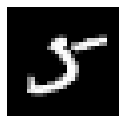

Label: 5


In [33]:
# The image to be displayed and tested
i = 136


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

<BarContainer object of 10 artists>

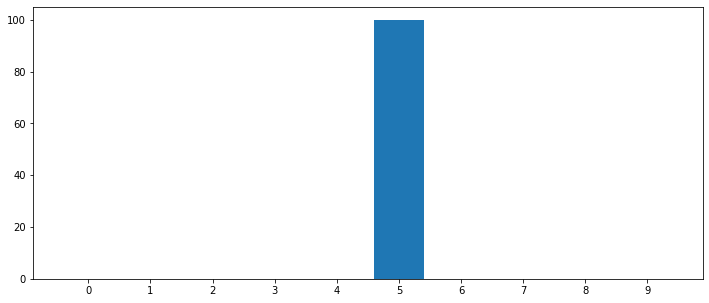

In [34]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])